# M044_2024_12_04_09_30

Session: M044_2024_12_04_09_30

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import pyaldata as pyal

from toolkit.dsp.preprocessing import preprocess


In [2]:
# TODO: add example data to the repo and run on that
data_dir = r"C:\data\raw\M044\M044_2024_12_04_09_30"
fname = os.path.join(data_dir, "M044_2024_12_04_09_30_pyaldata.mat")

In [3]:
# load TrialData .mat file into a DataFrame
df = pyal.mat2dataframe(fname, shift_idx_fields=True)

field values_before_camera_trigger could not be converted to int.
field idx_before_camera_trigger could not be converted to int.
array field all_KSLabel could not be converted to int.


## Preprocessing from utils

In [4]:
df_ = preprocess(df)

C:\Users\MartinEsparzaINBRAIN\AppData\Local\pypoetry\Cache\virtualenvs\earthquake-analysis-dAG31IpV-py3.12\Lib\site-packages\pyaldata\firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


Combined every 3 bins
Resulting all_spikes ephys data shape is (NxT): (474, 133)


## Preprocessing

In [184]:
time_signals = ['CP_spikes', 'MOp_spikes']
for signal in time_signals:
    df_ = pyal.remove_low_firing_neurons(df, signal, 1)  # Remove low firing (below 1 Hz) spikes from each spike trace 

C:\Users\MartinEsparzaINBRAIN\AppData\Local\pypoetry\Cache\virtualenvs\earthquake-analysis-dAG31IpV-py3.12\Lib\site-packages\pyaldata\firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
C:\Users\MartinEsparzaINBRAIN\AppData\Local\pypoetry\Cache\virtualenvs\earthquake-analysis-dAG31IpV-py3.12\Lib\site-packages\pyaldata\firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


In [186]:
df_ = pyal.merge_signals(df_, time_signals, 'MOp_CP_spikes')
df_.MOp_CP_spikes[0].shape

(60001, 442)

In [187]:
df_ = pyal.select_trials(df_, "trial_name == 'trial'")  # Remove baseline
df_ = pyal.select_trials(df_, "idx_trial_end > 90000")  # Remove first 5 minutes because the switch was off
df_ = pyal.select_trials(df_, "idx_trial_end > 90000")  # Remove first 5 minutes because the switch was off

In [188]:
df_.head().idx_trial_end

0    91099
1    91599
2    92299
3    93199
4    93699
Name: idx_trial_end, dtype: int64

In [189]:
BIN_SIZE = 0.03
df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))  # Pass it to times bins of 0.03

In [191]:
print("original: ", df.MOp_spikes[2].shape)
print("combined: ", df_.MOp_CP_spikes[0].shape)

original:  (401, 578)
combined:  (133, 442)


### Why sqrt the data?
Data from a poisson process have heteroscedasticity --> Unequal variance across different firing rates. The square root transformation stabilizes the variance because the variance of a Poisson process becomes approximately constant after applying this transformation. This makes the data more suitable for statistical analyses that assume homoscedasticity.

In [192]:
time_signals = [signal for signal in pyal.get_time_varying_fields(df_) if 'spikes' in signal]
for signal in time_signals:
    df_ = pyal.sqrt_transform_signal(df_, signal)

In [193]:
df_ = pyal.add_firing_rates(df_, 'smooth', std=0.05)

In [194]:
df_.head()

,animal,session,trial_id,trial_name,trial_length,bin_size,idx_trial_start,idx_trial_end,idx_CPI,values_before_camera_trigger,...,CP_spikes,MOp_chan_best,MOp_KSLabel,MOp_spikes,MOp_CP_spikes,scwm_rates,ccb_rates,CP_rates,MOp_rates,MOp_CP_rates
0,M044,M044_2024_12_04_09_30,82,trial,401,0.03,30233,30366,[],[],...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 6...","[good, mua, mua, good, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.00031967516, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21239205, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.034771092, 0.0, 0.0, 0.0, 23.380...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,M044,M044_2024_12_04_09_30,84,trial,401,0.03,30399,30533,[],[],...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 6...","[good, mua, mua, good, good, good, good, good,...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[6.201384, 6.201384, 2.798774, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 2.798774, 0.0, 3.0111659, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9141243...","[[1.1265163, 0.0, 0.0, 16.662374, 0.0, 9.03492...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9141243..."
2,M044,M044_2024_12_04_09_30,86,trial,401,0.03,30633,30766,[],[],...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 6...","[good, mua, mua, good, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.91412437, 0.0, 2.833545, 0....","[[2.8027468, 25.524176, 0.0, 0.0, 0.0, 0.0, 0....","[[0.0, 0.0, 10.460135, 8.7700815, 0.0, 0.03477...","[[2.8027468, 25.524176, 0.0, 0.0, 0.0, 0.0, 0...."
3,M044,M044_2024_12_04_09_30,88,trial,401,0.03,30933,31066,[],[],...,"[[0.0, 1.4142135623730951, 0.0, 0.0, 0.0, 0.0,...","[66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 6...","[good, mua, mua, good, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 1.4142135623730951, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.00031967516, 0.0,...","[[0.0, 18.313324, 0.034771092, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 3.712898, 0.0, 0.21239205, 0.0, 0....","[[0.0, 18.313324, 0.034771092, 0.0, 0.0, 0.0, ..."
4,M044,M044_2024_12_04_09_30,90,trial,401,0.03,31099,31233,[],[],...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 67, 6...","[good, mua, mua, good, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.91412437, 0.0, 0.0, 32.1682...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Plotting

In [5]:
df_ = pyal.select_trials(df_, "idx_trial_end > 30365")  # Remove first 5 minutes because the switch was off

In [6]:
df_.head()

,animal,session,trial_id,trial_name,trial_length,bin_size,idx_trial_start,idx_trial_end,idx_CPI,values_before_camera_trigger,...,values_Sol_duration,idx_Sol_duration,idx_sol_on,idx_earthquake_duration,idx_session_timer,all_chan_best,all_unit_guide,all_KSLabel,all_spikes,all_rates
0,M044,M044_2024_12_04_09_30,2,trial,401,0.03,20033,20166,[],[],...,50,-1,66,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 2.798774, 0.0, 2.798774, 2.79..."
1,M044,M044_2024_12_04_09_30,4,trial,401,0.03,20199,20333,[],[],...,100,-1,66,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.91809744, 0.0, 0...."
2,M044,M044_2024_12_04_09_30,6,trial,401,0.03,20366,20499,[],[],...,150,-1,66,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[3.0603397, 0.0, 0.0, 0.0, 3.0111659, 0.0, 0...."
3,M044,M044_2024_12_04_09_30,8,trial,401,0.03,20733,20866,[],[],...,150,-1,66,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[0.0, 0.0, 0.0, 2.798774, 0.0, 0.034771092, 0..."
4,M044,M044_2024_12_04_09_30,10,trial,401,0.03,21033,21166,[],[],...,150,-1,66,[],[],"[0, 0, 0, 1, 1, 1, 2, 3, 3, 3, 3, 3, 5, 5, 5, ...","[[0, 1], [5, 1], [5, 3], [6, 2], [8, 2], [9, 1...","[good, mua, good, mua, good, good, good, good,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,...","[[0.053146865, 0.0, 0.04949343, 0.0, 0.0, 12.9..."


In [7]:
df_.columns

Index(['animal', 'session', 'trial_id', 'trial_name', 'trial_length',
       'bin_size', 'idx_trial_start', 'idx_trial_end', 'idx_CPI',
       'values_before_camera_trigger', 'idx_before_camera_trigger',
       'idx_motion', 'values_Sol_direction', 'idx_Sol_direction',
       'values_Sol_duration', 'idx_Sol_duration', 'idx_sol_on',
       'idx_earthquake_duration', 'idx_session_timer', 'all_chan_best',
       'all_unit_guide', 'all_KSLabel', 'all_spikes', 'all_rates'],
      dtype='object')

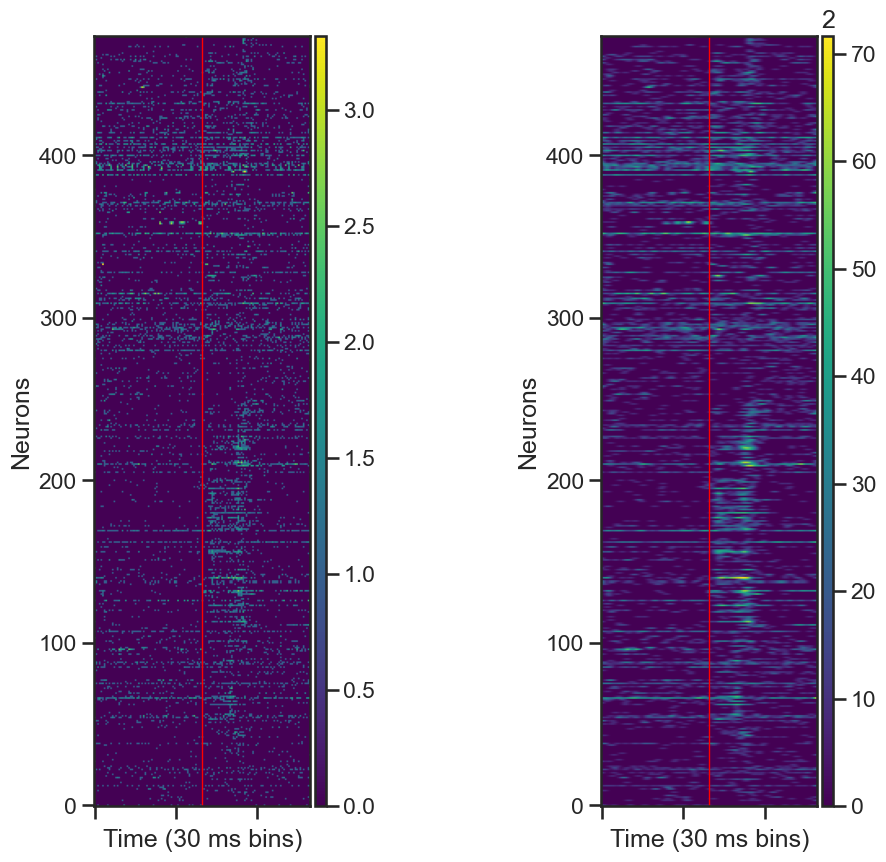

In [15]:
trial = 5
area = 'all'
from mpl_toolkits.axes_grid1 import make_axes_locatable
with plt.style.context('seaborn-v0_8-bright'):
    sns.set_theme(context='talk', style='ticks', font='Arial')
    fig, ax = plt.subplots(1, 2, sharex='all', figsize=(12, 10))
    im1 = ax[0].imshow(df_[f"{area}_spikes"][trial].T, cmap='viridis', origin='lower')
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax)
    
    im2 = ax[1].imshow(df_[f"{area}_rates"][trial].T, cmap='viridis', origin='lower')
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)
    for ax_ in ax:
        plt.title(f"{df_.loc[trial].values_Sol_direction}")
        ax_.axvline(x = df_.loc[trial].idx_sol_on, color='red', linewidth = '1')
        ax_.set_ylabel('Neurons')
        ax_.set_xlabel('Time (30 ms bins)')
        ax_.set_xticklabels([])
    plt.show()

In [16]:
df_solenoid_0 = df_.drop('all_KSLabel', axis=1)
df_solenoid_0 = pyal.select_trials(df_solenoid_0, "values_Sol_direction == 2")  # Remove first 5 minutes because the switch was off
df_solenoid_0_average = pyal.trial_average(df_solenoid_0, condition=None)

ValueError: operands could not be broadcast together with shapes (6,) (2,) 

In [34]:
df_solenoid_0_average

,trial_id,trial_length,bin_size,idx_trial_start,idx_trial_end,idx_Sol_direction,idx_Sol_duration,idx_sol_on,animal,session,trial_name,idx_CPI,values_before_camera_trigger,idx_before_camera_trigger,idx_earthquake_duration,idx_session_timer,all_chan_best,all_unit_guide,all_spikes,all_rates
0,603.567568,401.0,0.03,98729.081081,98862.351351,-1.0,-1.0,66.0,M044,M044_2024_12_04_09_30,trial,[],[],[],[],[],"[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 3.0, 3.0, ...","[[0.0, 1.0], [5.0, 1.0], [5.0, 3.0], [6.0, 2.0...","[[0.02702702702702703, 0.0, 0.1081081081081081...","[[1.6940359, 0.3657637, 2.9292977, 2.0149183, ..."


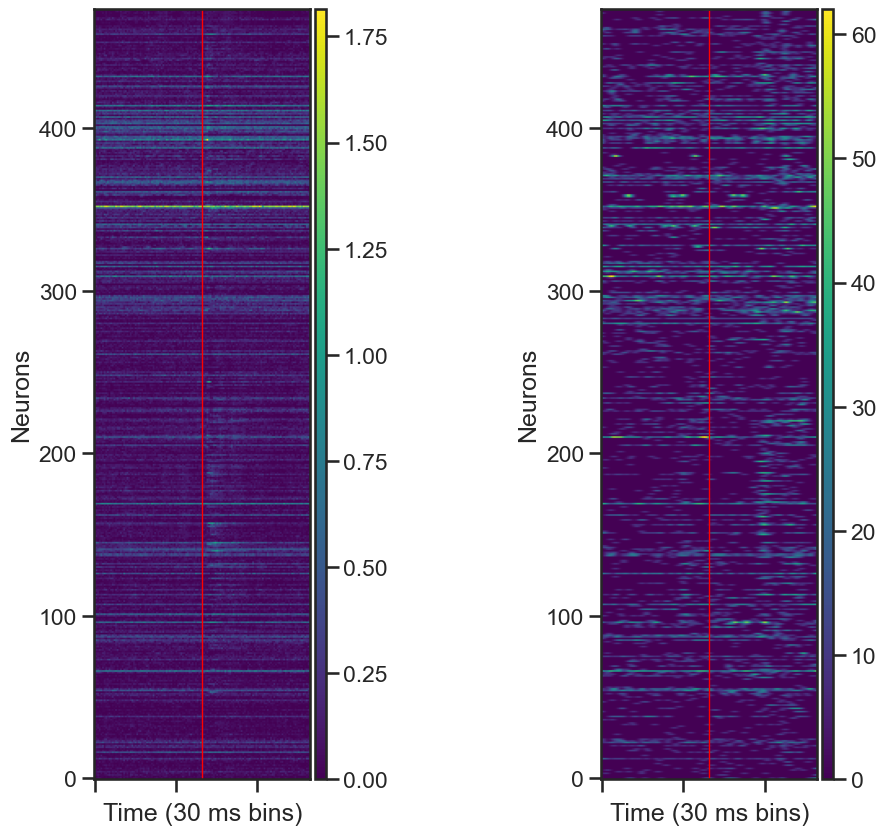

In [35]:
trial = 0
from mpl_toolkits.axes_grid1 import make_axes_locatable
with plt.style.context('seaborn-v0_8-bright'):
    sns.set_theme(context='talk', style='ticks', font='Arial')
    fig, ax = plt.subplots(1, 2, sharex='all', figsize=(12, 10))
    im1 = ax[0].imshow(df_solenoid_0_average[f"{area}_spikes"][trial].T, cmap='viridis', origin='lower')
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax)
    
    im2 = ax[1].imshow(df_[f"{area}_rates"][trial].T, cmap='viridis', origin='lower')
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)
    for ax_ in ax:
        ax_.axvline(x = df_solenoid_0_average.loc[trial].idx_sol_on, color='red', linewidth = '1')
        ax_.set_ylabel('Neurons')
        ax_.set_xlabel('Time (30 ms bins)')
        ax_.set_xticklabels([])
    plt.show()